In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from kmeans_pytorch import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn import datasets
import numpy as np
from tqdm.auto import tqdm

In [ ]:
def batchify(a, batch_size=512):
    n = (len(a) // batch_size) + len(a) % batch_size
    for i in np.array_split(a, n, axis=0):
        yield i


def plot_blobs(data,cluster_centers, labels, plot_file):    
    plt.figure(figsize=(4, 3), dpi=160)
    pca = PCA(n_components=2)
    master = np.concatenate([data, cluster_centers], 0)
    pca = pca.fit(master)
    data = pca.transform(data)
    plt.scatter(data[:, 0], data[:, 1], c=labels)
    cluster_centers = pca.transform(cluster_centers)
    plt.scatter(
        cluster_centers[:, 0], cluster_centers[:, 1],
        c='white',
        alpha=0.6,
        edgecolors='black',
        linewidths=2
    )
    #plt.axis([-1, 1, -1, 1])
    plt.tight_layout()
    plt.savefig(plot_file, dpi=300)

running k-means on cuda:0..


[running kmeans]: 0it [00:00, ?it/s]

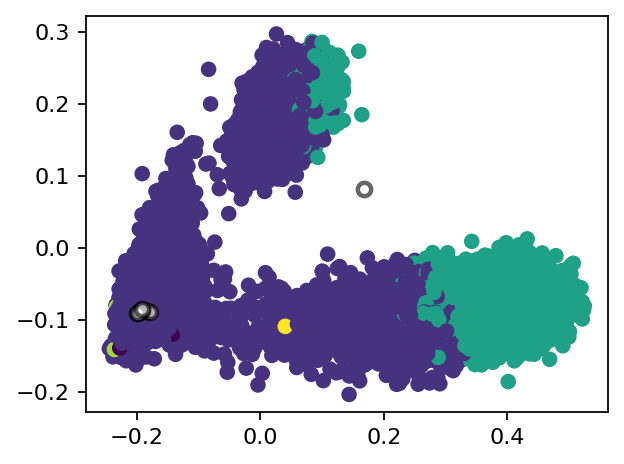

In [4]:
seed = 235
num_clusters = 8
balanced = True
debug = True
# set random seed
np.random.seed(seed)


# make new dataset
n_samples = 8000
blobs = datasets.make_blobs(n_samples=n_samples,
                            random_state=seed,
                            centers=[[1, 1], [-1, -1], [1, -1]],
                            cluster_std=0.6)
X = torch.from_numpy(blobs[0][:n_samples//2])
y = torch.from_numpy(blobs[0][n_samples//2:])

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

# setup KMeans
kmeans = KMeans(n_clusters=8, device=torch.device('cuda:0'), balanced=True)

_ = kmeans.fit(
    X=X.to(device), distance='euclidean', iter_limit=100, tqdm_flag=True, online=False
)

kmeans.save("model.pkl")


In [ ]:
kmeans = kmeans.load("model.pkl")

cluster_ids_y_ = []

cluster_ids_y = kmeans.predict(
        X=y.to(device)
    )

if balanced:
    output = 'balanced_clusters.pdf'
else:
    output = 'unbalanced_clusters.pdf'
plot_blobs(y, kmeans.cluster_centers.to('cpu'), cluster_ids_y, output)